# How to split the tfrecord files.
This file works for TF2. So, check the version.

In [3]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [24]:
raw_dataset = tf.data.TFRecordDataset("/content/eval_default.tfrecord")
print(raw_dataset)

<TFRecordDatasetV2 shapes: (), types: tf.string>


# Read the tfrecord

In [25]:
raw_dataset = tf.data.TFRecordDataset("/content/eval_default.tfrecord")

number_of_records = 3

for raw_record in raw_dataset.take(number_of_records):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)
    print("_____________________________ next _________________________________\n")

features {
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\002X\004\000\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#B\261\301\025R\321\360$3br\202\t\n\026\027\030\031\032%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\203\204\205\206\207\210\211\212\222\223\224\225\226\227\230\231\232\242\243\244\245\246\247

# Number of records in the tfrecord

In [26]:
sum(1 for _ in tf.data.TFRecordDataset("/content/eval_default.tfrecord"))

30

# Buffer and shuffle
The buffer_size in Dataset.shuffle() can affect the randomness of your dataset, and hence the order in which elements are produced. The buffer_size in Dataset.prefetch() only affects the time it takes to produce the next element.

Here my dataset is of size 30, so I gave buffer_size = 30

links: https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

https://stackoverflow.com/questions/51125266/how-do-i-split-tensorflow-datasets

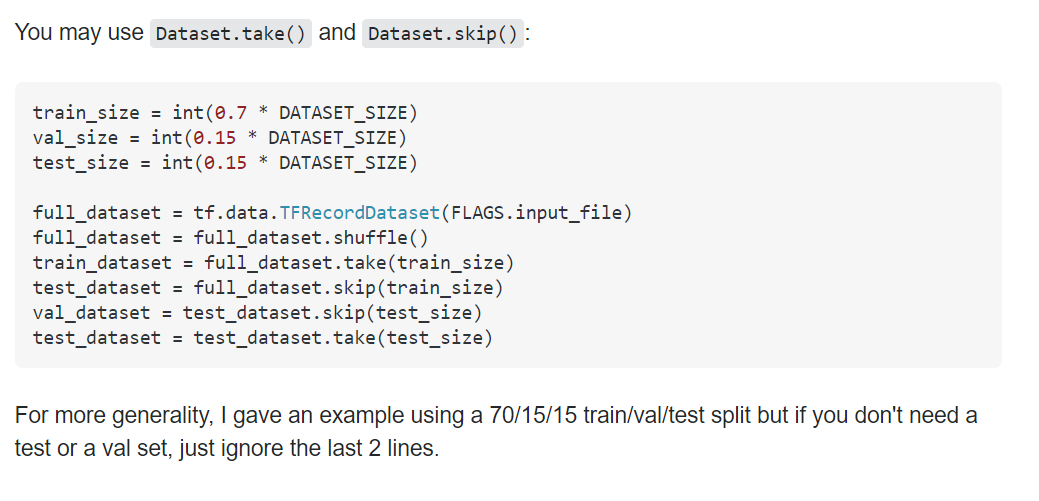

In [29]:
DATASET_SIZE = 30
input_file = "/content/eval_default.tfrecord"

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)


full_dataset = tf.data.TFRecordDataset(input_file)
full_dataset = full_dataset.shuffle(buffer_size=30)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [30]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [34]:
writer = tf.data.experimental.TFRecordWriter(f"train.tfrecord")
writer.write(train_dataset)
writer = tf.data.experimental.TFRecordWriter(f"test.tfrecord")
writer.write(test_dataset)
writer = tf.data.experimental.TFRecordWriter(f"eval.tfrecord")
writer.write(val_dataset)

In [35]:
def give_sum_of_records(file_path):
  print("File name: ",file_path.split("/")[-1])
  print(sum(1 for _ in tf.data.TFRecordDataset(file_path)))

give_sum_of_records("/content/eval.tfrecord")
give_sum_of_records("/content/test.tfrecord")
give_sum_of_records("/content/train.tfrecord")

File name:  eval.tfrecord
5
File name:  test.tfrecord
4
File name:  train.tfrecord
21


My dataset size is 30. I gave "shards" = 3, which means my dataset is going to be split into 3 datasets, having 10 images each.

In [45]:
%cd /content/Split_output
raw_dataset = tf.data.TFRecordDataset("/content/eval_default.tfrecord")

shards = 3

for i in range(shards):
    writer = tf.data.experimental.TFRecordWriter(f"output_file-part-{i}.tfrecord")
    print(writer)
    writer.write(raw_dataset.shard(shards, i))


/content/Split_output


In [46]:
import os
file_path = "/content/Split_output/"
list_of_records = os.listdir(file_path)
list_of_records = [file_path+x for x in list_of_records]

for record in list_of_records:
  give_sum_of_records(record)


File name:  output_file-part-0.tfrecord
8
File name:  output_file-part-3.tfrecord
7
File name:  output_file-part-1.tfrecord
8
File name:  output_file-part-2.tfrecord
7


# Combine multiple tfrecord files
Change the path to your tfrecord files in the list

Link: https://stackoverflow.com/questions/50265211/how-can-i-merge-multiple-tfrecords-file-into-one-file

In [36]:
list_of_tfrecord_files = ["/content/test.tfrecord", "/content/eval.tfrecord", "/content/train.tfrecord"]

dataset = tf.data.TFRecordDataset(list_of_tfrecord_files)

# Save dataset to .tfrecord file
filename = 'combined.tfrecord'

writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(dataset)

In [37]:
sum(1 for _ in tf.data.TFRecordDataset("/content/combined.tfrecord"))

30

# Create different sets of train and eval datasets

In [42]:
%cd /content/

# change the name when re-running
# name of the file where the data will go when we do splitting
split_output_file_name = "Final_split_ver3"
!mkdir {split_output_file_name}

# Change the output file name
out_put_file_name = "Final_output_ver3"

/content


In [43]:
import os

# sum of records
def give_sum_of_records(file_path):
  print("File name: ",file_path.split("/")[-1])
  print(sum(1 for _ in tf.data.TFRecordDataset(file_path)))

# Split the record file
def split_the_record(file_path,num_of_splits,output_dir_name):
  %cd {output_dir_name}
  raw_dataset = tf.data.TFRecordDataset(file_path)
  shards = num_of_splits
  for i in range(shards):
      writer = tf.data.experimental.TFRecordWriter(f"file_{i}.tfrecord")
      print(writer)
      writer.write(raw_dataset.shard(shards, i))

num_of_splits = 6                                         # Number of splits
file_path = "/content/eval_default.tfrecord"              # Main tfrecord file name
output_dir_name = split_output_file_name                  # dir where the split datasets will be stored 

split_the_record(file_path,num_of_splits,output_dir_name)

/content/Final_split_ver3


In [44]:
# listing the files created

file_path = "/content/"+output_dir_name+"/"
list_of_records = os.listdir(file_path)
list_of_records.sort()
list_of_records = [file_path+x for x in list_of_records]

for i in range(len(list_of_records)):
  print(list_of_records[i])

print("\nNumber of records:",len(list_of_records))

/content/Final_split_ver3/file_0.tfrecord
/content/Final_split_ver3/file_1.tfrecord
/content/Final_split_ver3/file_2.tfrecord
/content/Final_split_ver3/file_3.tfrecord
/content/Final_split_ver3/file_4.tfrecord
/content/Final_split_ver3/file_5.tfrecord

Number of records: 6


In [45]:
%cd /content/

!mkdir /content/{out_put_file_name}

%cd /content/{out_put_file_name}

for i in range(0,len(list_of_records)):
  print("Eval:",list_of_records[i])
  temp = [list_of_records[x] for x in range(len(list_of_records)) if x != i]
  print("train:",temp)

  # For eval dataset
  list_of_tfrecord_files = list_of_records[i]
  dataset = tf.data.TFRecordDataset(list_of_tfrecord_files)

  # # Save dataset to .tfrecord file
  filename = 'eval_'+str(i)+'.tfrecord'

  writer = tf.data.experimental.TFRecordWriter(filename)
  writer.write(dataset)

  # temp_list_of_records = [list_of_records[x] for x in range(len(list_of_records)) if x != i]
  # print("Train !!!!!!! ",temp_list_of_records,"\n")

  # # For training dataset
  list_of_tfrecord_files = temp
  dataset = tf.data.TFRecordDataset(list_of_tfrecord_files)

  # # Save dataset to .tfrecord file
  filename = 'train_'+str(i)+'.tfrecord'

  writer = tf.data.experimental.TFRecordWriter(filename)
  writer.write(dataset)

/content
/content/Final_output_ver3
Eval: /content/Final_split_ver3/file_0.tfrecord
train: ['/content/Final_split_ver3/file_1.tfrecord', '/content/Final_split_ver3/file_2.tfrecord', '/content/Final_split_ver3/file_3.tfrecord', '/content/Final_split_ver3/file_4.tfrecord', '/content/Final_split_ver3/file_5.tfrecord']
Eval: /content/Final_split_ver3/file_1.tfrecord
train: ['/content/Final_split_ver3/file_0.tfrecord', '/content/Final_split_ver3/file_2.tfrecord', '/content/Final_split_ver3/file_3.tfrecord', '/content/Final_split_ver3/file_4.tfrecord', '/content/Final_split_ver3/file_5.tfrecord']
Eval: /content/Final_split_ver3/file_2.tfrecord
train: ['/content/Final_split_ver3/file_0.tfrecord', '/content/Final_split_ver3/file_1.tfrecord', '/content/Final_split_ver3/file_3.tfrecord', '/content/Final_split_ver3/file_4.tfrecord', '/content/Final_split_ver3/file_5.tfrecord']
Eval: /content/Final_split_ver3/file_3.tfrecord
train: ['/content/Final_split_ver3/file_0.tfrecord', '/content/Final_spli

In [46]:
file_path = "/content/"+out_put_file_name+"/"

list_of_records = os.listdir(file_path)
list_of_records.sort()
list_of_records = [file_path+x for x in list_of_records]

for record in list_of_records:
  give_sum_of_records(record)

print("\nNumber of records:",len(list_of_records))

File name:  eval_0.tfrecord
5
File name:  eval_1.tfrecord
5
File name:  eval_2.tfrecord
5
File name:  eval_3.tfrecord
5
File name:  eval_4.tfrecord
5
File name:  eval_5.tfrecord
5
File name:  train_0.tfrecord
25
File name:  train_1.tfrecord
25
File name:  train_2.tfrecord
25
File name:  train_3.tfrecord
25
File name:  train_4.tfrecord
25
File name:  train_5.tfrecord
25

Number of records: 12
